In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

In [72]:
def warpTwoImagesInv(img1, img2, H_inv):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts1_ = cv2.perspectiveTransform(pts1, H_inv)
    pts = np.concatenate((pts1_, pts2), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img1, Ht.dot(H_inv), (xmax-xmin, ymax-ymin))
    img2_rect = np.int32([t[1], h1+t[1],t[0], w1+t[0]])
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img2
    return result, img2_rect

In [131]:
img1_color = cv2.imread("../data/stitching/boat1.jpg", -1)
img2_color = cv2.imread("../data/stitching/boat2.jpg", -1)
img3_color = cv2.imread("../data/stitching/boat3.jpg", -1)
img4_color = cv2.imread("../data/stitching/boat4.jpg", -1)
img5_color = cv2.imread("../data/stitching/boat5.jpg", -1)
img6_color = cv2.imread("../data/stitching/boat6.jpg", -1)

In [132]:
sift = cv2.SIFT_create()
# orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, desc1 = sift.detectAndCompute(img1_color, None)
kp2, desc2 = sift.detectAndCompute(img2_color, None)
desc1 = np.float32(desc1)
desc2 = np.float32(desc2)

# FLANN parameters: Fast Library for Approximate Nearest Neighbor
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# K=2 => get 2 Nearest Neighbors which is then filtered out after applying a ratio test
# This filters out around 90% of false matches
#(Learning OpenCV 3 Computer Vision with Python By Joe Minichino, Joseph Howse)
matches = flann.knnMatch(desc1, desc2, k=2)                 # Interest points from image2 to image1


# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

dst_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
src_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

plt.figure(figsize=(9,16))
result = warpTwoImages(img1_color, img2_color, M)
plt.imshow(result)

In [137]:
dst_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
src_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)
M_inv, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

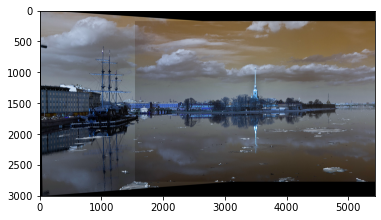

In [138]:
img1 = img1_color
img2 = img2_color
H_inv = M_inv
'''warp img2 to img1 with homograph H'''
h1,w1 = img1.shape[:2]
h2,w2 = img2.shape[:2]
pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
pts1_ = cv2.perspectiveTransform(pts1, H_inv)
pts = np.concatenate((pts1_, pts2), axis=0)
[xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
t = [-xmin, -ymin]
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

result = cv2.warpPerspective(img1, Ht.dot(H_inv), (xmax-xmin, ymax-ymin))
# img2_rect = np.int32([t[1], h1+t[1],t[0], w1+t[0]])
result[t[1]:h2+t[1],t[0]:w2+t[0]] = img2
# result[t[1]:h1+t[1],t[0]:w1+t[0]] = img2
# return result, img2_rect
plt.imshow(result)